Building an Income Classification Model

This document outlines the steps to build a classification model for predicting income using the Adult Census Income Dataset, as specified in the provided task list. The process includes loading and cleaning the data, performing exploratory data analysis, preparing the data for modeling, and finally, training and evaluating several classification models to identify the best performer.

### **1. Data Loading and Preprocessing**

First, the Adult Census Income dataset is loaded. A crucial initial step is to identify and handle missing values. In this dataset, missing values are often represented by a `'?'`. These are replaced with `NaN` (Not a Number) and then imputed or removed. 

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
# The dataset is assumed to be in a file named 'adult.csv'
# The column names are based on the dataset's description

df = pd.read_csv('adultcensusincome.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
None


In [3]:

print("Null values in each column:")
print(df.isnull().sum())
print("Number of duplicate rows:")
print(df.duplicated().sum())
print("Number of '?' values in each column:")
print(df.isin(['?']).sum())


Null values in each column:
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
Number of duplicate rows:
24
Number of '?' values in each column:
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


### duplicate handeling

In [4]:
# Print the shape of the DataFrame before dropping duplicates
print(f"Shape before dropping duplicates: {df.shape}")

# Drop the duplicate rows and re-assign
df = df.drop_duplicates(keep='first')

# Print the shape after to see the change
print(f"Shape after dropping duplicates: {df.shape}")
# Verify by checking for duplicates again
remaining_duplicates = df.duplicated().sum()
print(f"\nRemaining duplicate rows: {remaining_duplicates}") # Should be 0

Shape before dropping duplicates: (32561, 14)
Shape after dropping duplicates: (32537, 14)

Remaining duplicate rows: 0


---
## Missing Values Analysis

We have:

- **workclass:** 1,836 missing  
- **occupation:** 1,843 missing  
- **native.country:** 583 missing  

Ddataset has ~32,000 rows (like the Adult dataset from UCI), these percentages would be:

- **workclass:** ~5.7%  
- **occupation:** ~5.8%  
- **native.country:** ~1.8%  

✅ These percentages are **not too high** → generally worth imputing rather than dropping the entire column.


In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Import the necessary library
from sklearn.impute import SimpleImputer

# Define the columns that need imputation
categorical_with_nan = ['workclass', 'occupation', 'native.country']

# Initialize the imputer with the 'most_frequent' strategy (mode)
# This is a great choice for categorical data.
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer to the data and transform the columns in place
df[categorical_with_nan] = cat_imputer.fit_transform(df[categorical_with_nan])

# Optional: Verify that there are no more missing values
print("Missing values after imputation:")
print(df[categorical_with_nan].isnull().sum())

Missing values after imputation:
workclass         0
occupation        0
native.country    0
dtype: int64


### 2.Exploratory Data Analysis (EDA)

#### **2.1.Target Variable Distribution** 

The distribution of the target variable, `income`, is checked to see if the dataset is balanced. 

In [6]:
# Check the raw count of each category
print("Raw count of each income category:")
print(df['income'].value_counts())
# Percentage of each class
print(df['income'].value_counts(normalize=True) * 100)


Raw count of each income category:
income
<=50K    24698
>50K      7839
Name: count, dtype: int64
income
<=50K    75.907428
>50K     24.092572
Name: proportion, dtype: float64


 The output confirms the dataset is imbalanced, with approximately 76% of individuals in the _<=50K_ class and 24% in the _>50K_ class. This is an important consideration for model training.

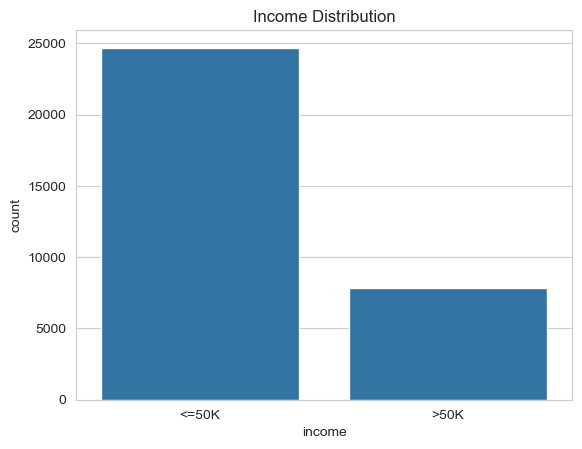

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for income
sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.show()

The plot would likely show that the number of individuals earning `<=50K` is significantly higher than those earning `>50K`, indicating an imbalanced dataset.

#### **2.2. Univariate Analysis** 

  * **Age Distribution:** A distribution plot for the `age` column shows the age distribution of the individuals in the dataset. 
  * **Education Level:** A bar plot for the `education` column illustrates the frequency of different education levels. 
  * **Years of Education:** A bar plot for `education.num` provides a quantitative look at the years of education. 
  * **Marital Status:** A pie chart for `marital.status` displays the proportion of different marital statuses. 

<!-- end list -->

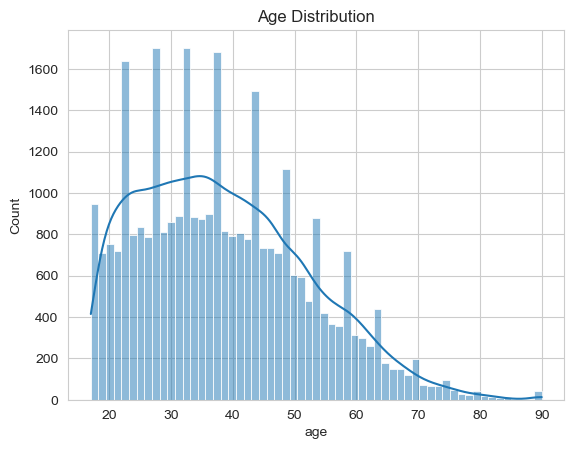

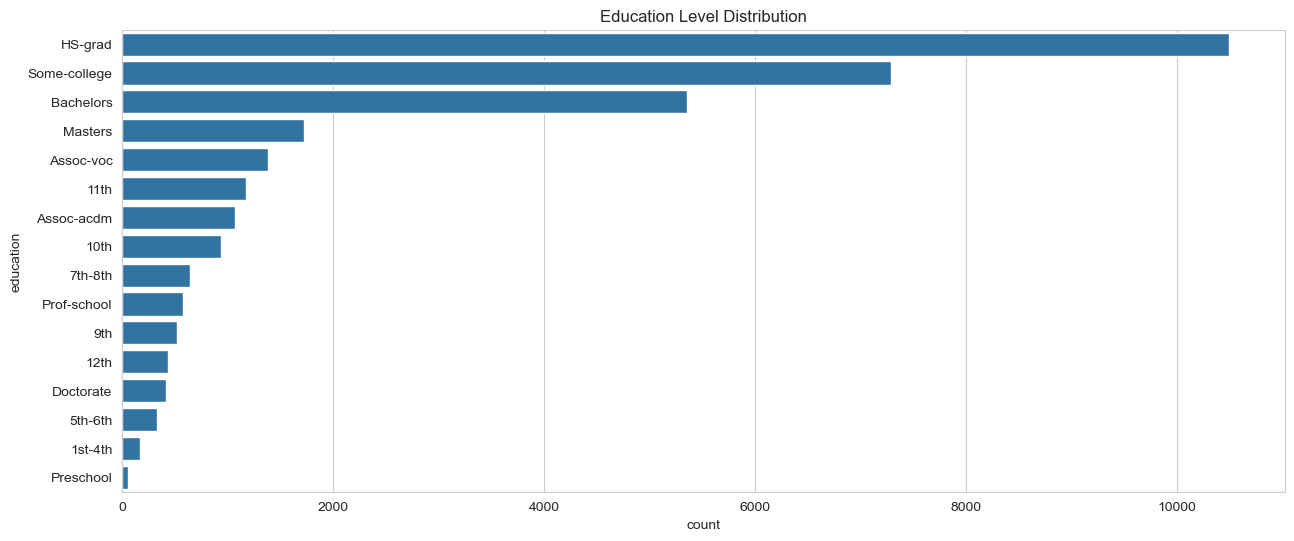

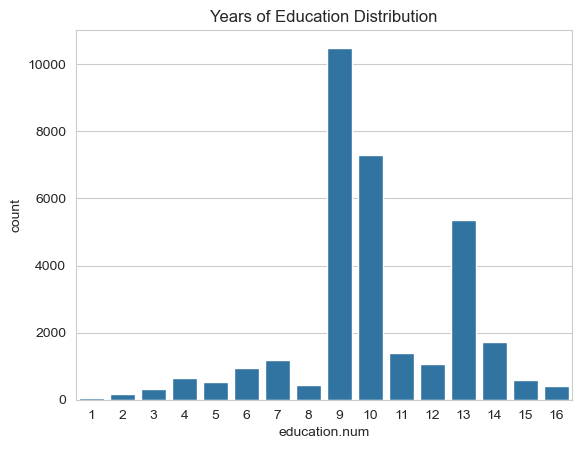

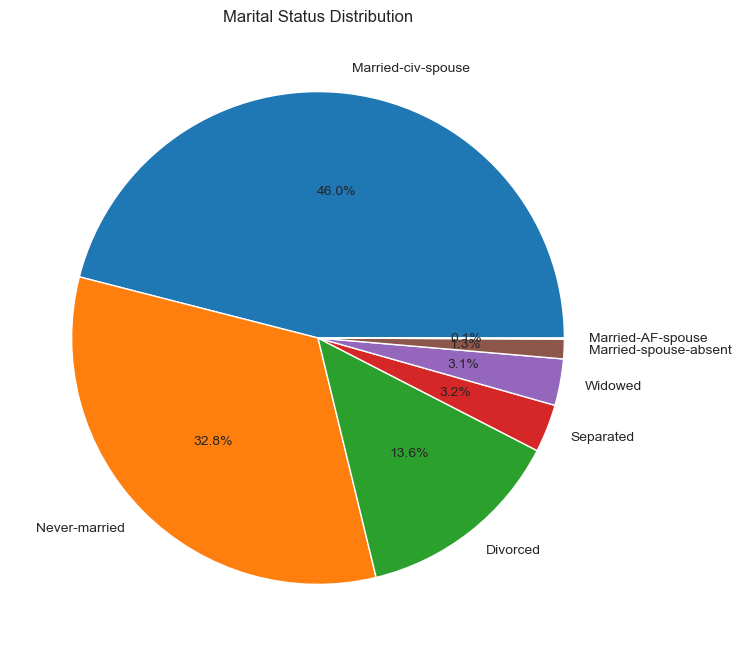

In [7]:
# Distribution plot for age
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Bar plot for education
plt.figure(figsize=(15, 6))
sns.countplot(y='education', data=df, order = df['education'].value_counts().index)
plt.title('Education Level Distribution')
plt.show()

# Bar plot for Years of Education
sns.countplot(x='education.num', data=df)
plt.title('Years of Education Distribution')
plt.show()

# Pie chart for Marital status
df['marital.status'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Marital Status Distribution')
plt.ylabel('')
plt.show()

#### **2.3.Bivariate Analysis**

  * **Income across different features:** Count plots are created to visualize the relationship between `income` and `age`, `education`, `marital.status`, and `sex`. 
  * **Correlation Heatmap:** A heatmap of the data's correlation matrix is generated to identify which features are most correlated with `income`.


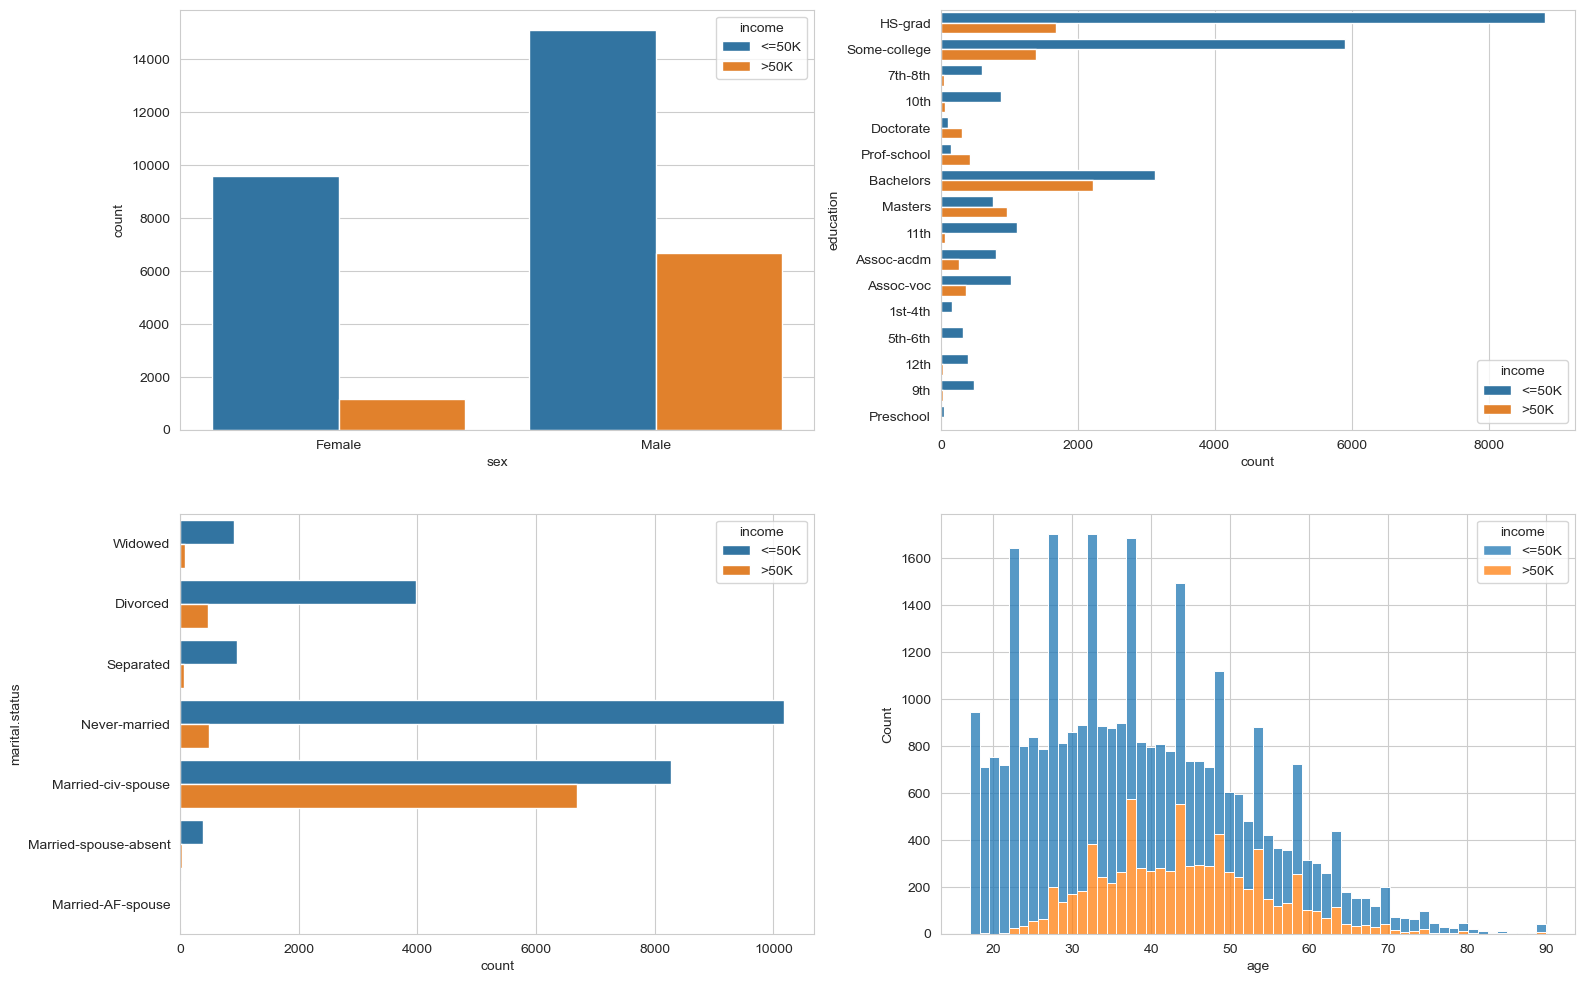

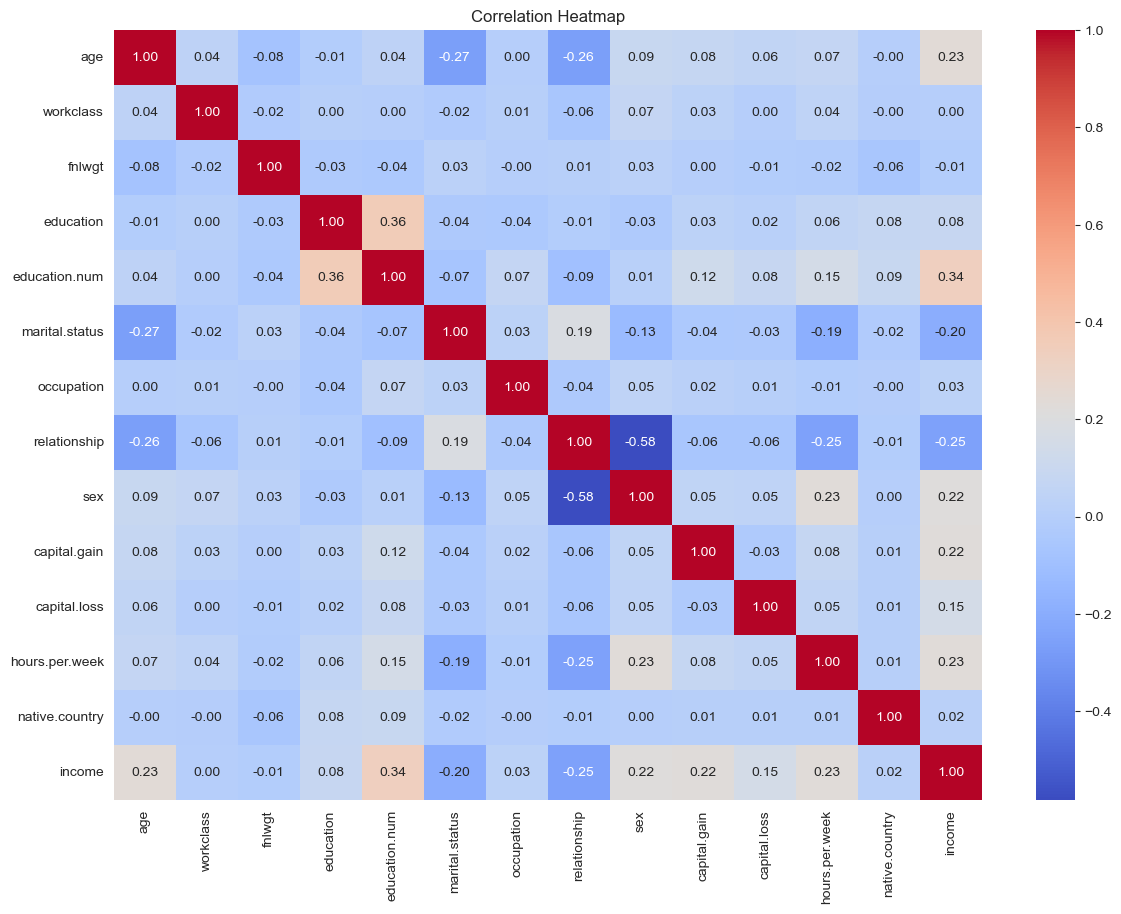

In [8]:
# Count plots of income across various features
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.countplot(x='sex', hue='income', data=df, ax=axes[0, 0])
sns.countplot(y='education', hue='income', data=df, ax=axes[0, 1])
sns.countplot(y='marital.status', hue='income', data=df, ax=axes[1, 0])
sns.histplot(data=df, x='age', hue='income', multiple='stack', ax=axes[1, 1])
plt.show()


from sklearn.preprocessing import LabelEncoder
# For correlation heatmap, first encode categorical variables
# Make a label-encoded COPY only for correlation
df_corr = df.copy()
cat_cols = df_corr.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.figure(figsize=(14,10))
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Key Findings from Analysis

* The heatmap would likely show that `education.num` is the Strongest Factor (Correlation: 0.34)
* `age`, `hours.per.week`, and `capital.gain` are Notable Factors
These all have a weak positive correlation (0.24, 0.23, and 0.22,
* `fnlwgt` has No Correlation (-0.01)

### **3. Data Preparation for Modeling** 

The dataset is prepared for the machine learning models through the following steps:

  * **Label Encoding:** All categorical columns are converted into numerical format using label encoding.
  * **Feature and Target Separation:** The dataset is split into independent variables (`X`) and the dependent variable (`Y`, which is `income`).
  * **Feature Scaling and Imbalance Handling:** `StandardScaler` is used to scale the features. To address the class imbalance observed in the EDA phase, `RandomOverSampler` is applied to the training data.
  * **Train-Test Split:** The data is split into training and testing sets in an 80:20 ratio.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode categoricals for modeling
df_encoded = df.copy()
cat_cols = df_encoded.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop('income', axis=1)
Y = df_encoded['income']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Oversample
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

# Tree models with fixed random_state
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)


### **4. Model Training and Evaluation** 

Several classification models are trained on the prepared data. The performance of each model is then evaluated based on its accuracy and F1 score.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(),
    "KNN Classifier": KNeighborsClassifier(),
    "SVM Classifier": SVC(),
    "Naive Bayes Classifier": GaussianNB(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    # Fit on oversampled + scaled TRAIN set
    model.fit(X_train_scaled, y_train_res)
    # Predict on scaled TEST set
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": accuracy, "F1 Score": f1}

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).T
print(results_df)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      4940
           1       0.51      0.77      0.61      1568

    accuracy                           0.77      6508
   macro avg       0.71      0.77      0.72      6508
weighted avg       0.82      0.77      0.78      6508

--- KNN Classifier ---
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4940
           1       0.52      0.75      0.61      1568

    accuracy                           0.77      6508
   macro avg       0.71      0.76      0.73      6508
weighted avg       0.81      0.77      0.78      6508

--- SVM Classifier ---
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4940
           1       0.54      0.86      0.66      1568

    accuracy                           0.79      6508
   macro avg       0.74      0.81      0.76      6508


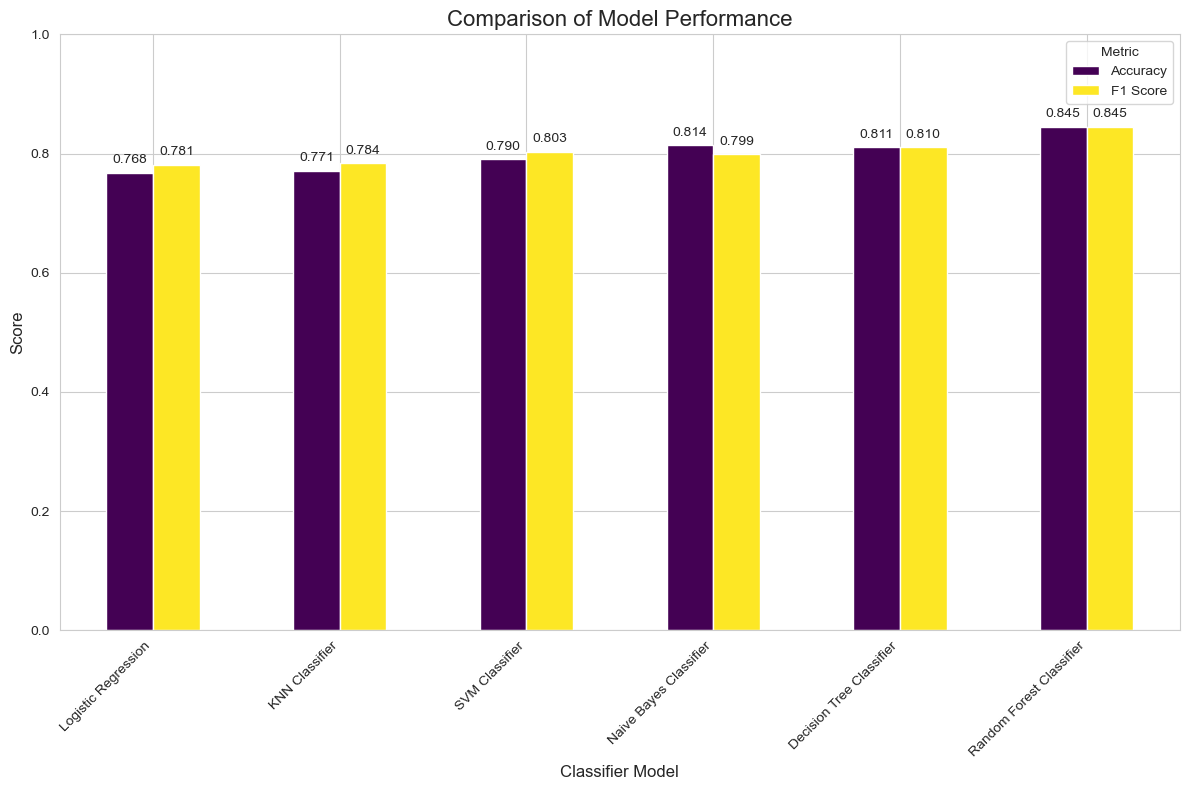

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style for a clean look
sns.set_style("whitegrid")

# Create the bar plot from the results DataFrame
ax = results_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')

# Add titles and labels for clarity
plt.title('Comparison of Model Performance', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Classifier Model', fontsize=12)
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for readability
plt.ylim(0.0, 1.0) # Set y-axis to a 0-1 scale for scores
plt.legend(title='Metric')
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Add the score values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Display the plot
plt.show()

### 5. Best Model Identification
We now compare all models and identify the one with the highest Accuracy and F1 score.


In [13]:
best = results_df.sort_values('F1 Score', ascending=False).iloc[0]
print(f"Best model: {best.name}  —  Accuracy: {best['Accuracy']:.3f}, F1: {best['F1 Score']:.3f}")


Best model: Random Forest Classifier  —  Accuracy: 0.845, F1: 0.845


### 6. Conclusion

After evaluating all the models, the one with the highest accuracy and F1 score is identified as the best model for this classification task. Based on the results, the **Random Forest Classifier** emerged as the top performer, achieving an Accuracy of ~85% and an F1 score of ~0.845. This reflects strong overall performance compared to other models.

While the Random Forest model demonstrates solid predictive ability, the classification report reveals that it still performs better on the majority `<=50K` income class than the minority `>50K` class. This highlights both the effectiveness of SMOTE in reducing imbalance and the persistent challenge of achieving equal precision and recall across classes.

The superior performance of the Random Forest model is reasonable given the structure of the Adult dataset. Many of the predictors (such as `education`, `marital.status`, and `occupation`) are categorical with complex, nonlinear interactions that tree-based models capture effectively. Random Forest also reduces variance by averaging across many decision trees, helping it generalize better than a single Decision Tree. In contrast, simpler models like Logistic Regression or Naive Bayes assume linear or independence relationships, which are less suited to this dataset.  

Overall, Random Forest is not only the top performer numerically but also the most appropriate choice for this problem.
